In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import minimize


obs_avoid_dist = 5

def create_environment(ind):
    # Randomly choose the obstacle positions, heights and the polynomial's starting and ending points
    x0, x1 = np.random.randint(1, 29, 2)
    while abs(x1 - x0) < 5:
        x1 = np.random.randint(1, 29)

    x0, x1 = np.sort([x0, x1])
    h0, h1 = np.random.randint(5, 25, 2)
    s, e = np.random.randint(0, 30, 2)

    xs = np.array([0, x0, x1, 30])
    ys = np.array([s, h0+obs_avoid_dist, 30-h1-obs_avoid_dist, e])

    p0 = np.polyfit(xs[:2], ys[:2], 2)
    p1 = np.polyfit(xs[1:3], ys[1:3], 2)
    p2 = np.polyfit(xs[2:], ys[2:], 2)



    plt.figure(figsize=(5, 5))
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.title('Map', color='white')

    # Plot obstacles
    plt.plot([x0, x0], [0, h0], color='red', linewidth=5)
    plt.plot([x1, x1], [30 - h1, 30], color='red', linewidth=5)

    # Plot polynomial curve
    xs = np.linspace(0, 30, 500)
    ys = []
    for x in xs:
        if x < x0:
            y = np.polyval(p0, x)
        elif x < x1:
            y = np.polyval(p1, x)
        else:
            y = np.polyval(p2, x)
        ys.append(y)    
    ys = np.array(ys)
    plt.plot(xs, ys, color='blue', linewidth=3)

    # Set the plot limits and labels
    plt.xlim(0, 30)
    plt.ylim(0, 30)
    plt.xlabel('x', color='white')
    plt.ylabel('y', color='white')

    # Save the plot
    plt.savefig(os.path.join(folder, f'environment{ind}.png'))
    plt.close()

    # # Define constraints to avoid obstacles
    # def constr_func(coeffs):
    #     poly = np.poly1d(coeffs)
    #     xs = np.linspace(0, 30, 100)
    #     return [
    #         min(poly(xs)),  # Polynomial must be above the x-axis
    #         max(poly(xs)) - 30,  # Polynomial must be below the top of the map
    #         poly(x0) - h0 - obs_avoid_dist,  # Polynomial must be above the first obstacle, ineq in the callee means it must be positive
    #         30 - poly(x1) - h1 + obs_avoid_dist # Polynomial must be below the second obstacle
    #     ]

    # # Minimize the integrated square of the polynomial's derivative (minimize curve length)
    # def objective(coeffs):
    #     poly = np.poly1d(coeffs)
    #     integral = np.polyint(poly.deriv()**2)
    #     return integral(30) - integral(0)

    # # Perform the optimization with constraints
    # result = minimize(objective, p0, constraints={'type': 'ineq', 'fun': constr_func})

    # # Check if a solution was found
    # if result.success:
    #     coeffs = result.x
    #     poly = np.poly1d(coeffs)

    #     # Create the plot
    #     plt.figure(figsize=(5, 5))
    #     ax = plt.gca()
    #     ax.set_facecolor('black')
    #     plt.title('Map', color='white')

    #     # Plot obstacles
    #     plt.plot([x0, x0], [0, h0], color='red', linewidth=5)
    #     plt.plot([x1, x1], [30 - h1, 30], color='red', linewidth=5)

    #     # Plot polynomial curve
    #     xs = np.linspace(0, 30, 500)
    #     ys = poly(xs)
    #     plt.plot(xs, ys, color='blue')

    #     # Set the plot limits and labels
    #     plt.xlim(0, 30)
    #     plt.ylim(0, 30)
    #     plt.xlabel('x', color='white')
    #     plt.ylabel('y', color='white')

    #     # Save the plot
    #     plt.savefig(os.path.join(folder, f'environment{ind}.png'))
    #     plt.close()

    #     return True
    # else:
    #     return False

# Generate the environment
folder = 'environments'
if not os.path.exists(folder):
    os.makedirs(folder)
for i in range(100):
    create_environment(i)

/home/yigit/.local/lib/python3.8/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


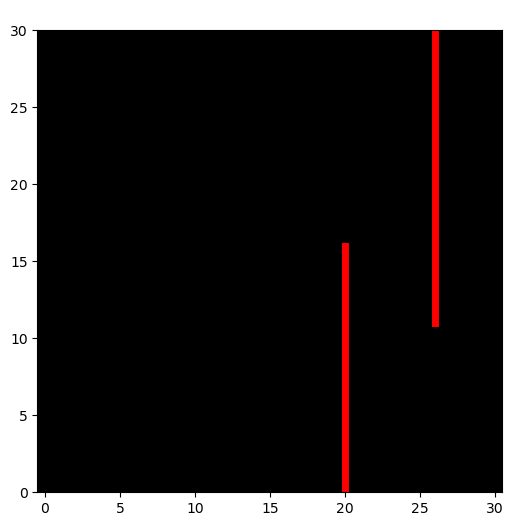

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import heapq


folder = 'environments'
if not os.path.exists(folder):
    os.makedirs(folder)


# Helper functions for A*
def heuristic(a, b):
    return np.sqrt((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2)

def get_neighbors(node):
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]
    result = []
    for d in directions:
        neighbor = (node[0] + d[0], node[1] + d[1])
        if 0 <= neighbor[0] < 30 and 0 <= neighbor[1] < 30:
            result.append(neighbor)
    return result

def a_star(start, goal, obstacles):
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, goal)}
    
    while open_set:
        current = heapq.heappop(open_set)[1]
        
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            return path[::-1] # Return reversed path
        
        for neighbor in get_neighbors(current):
            if neighbor in obstacles:
                continue
            
            tentative_g_score = g_score[current] + heuristic(current, neighbor)
            
            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, goal)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))
    
    return None


def check_valid(x, y, x0, h0, x1, h1):
    if np.any(np.isnan(y)) or not (np.all(0 <= y) and np.all(y <= 30)):
        return False
    
    # Check if the path is valid
    for i in range(len(x)):
        if x0 - obs_avoid_dist <= x[i] <= x0 + obs_avoid_dist and 0 <= y[i] <= h0:
            return False
        if x1 - obs_avoid_dist <= x[i] <= x1 + obs_avoid_dist and 30 - h1 <= y[i] <= 30:
            return False
    return True


obs_avoid_dist = 3
ind = 0
for test in range(10000):
    # if plt is open, close it
    plt.close()
    # Step 1: Randomly pick variables
    x0, x1 = np.random.randint(2, 28, 2)
    while abs(x1 - x0) < 5:
        x1 = np.random.randint(2, 28)

    x0, x1 = np.sort([x0, x1])
    h0, h1 = np.random.randint(5, 26, 2)
    s, e = np.random.randint(0, 31, 2)

    plt.figure(figsize=(5, 5))
    plt.xlim(-0.5, 30.5)
    plt.ylim(0, 30)
    plt.gca().set_facecolor('black')
    plt.title('Map', color='white')

    plt.plot([x0, x0], [0, h0], color='red', linewidth=5)
    plt.plot([x1, x1], [30-h1, 30], color='red', linewidth=5)

    # Defining obstacles based on x0, x1, h0, and h1
    obstacles = set()
    for i in range(h0 + obs_avoid_dist):
        obstacles.add((x0, i))
    for i in range(30 - h1 - obs_avoid_dist, 30):
        obstacles.add((x1, i))

    # Finding a path
    start = (0, s)
    goal = (29, e)

    path = a_star(start, goal, obstacles)
    if path is None:
        continue
    path = np.clip(path, 0, 30)

    path_array = np.array(path)

    x = path_array[:, 0]
    y = path_array[:, 1]


    degree = 3  # Degree of the smoothing spline
    spl = UnivariateSpline(x, y, s=len(path)) #make_interp_spline(x, y, k=degree)

    # Generate new, smoother x and y values
    x_smooth = np.linspace(x.min(), x.max(), 300)
    y_smooth = spl(x_smooth)

    # Check if the path is valid
    is_valid = check_valid(x_smooth, y_smooth, x0, h0, x1, h1)

    if not is_valid:
        continue

    
    plt.savefig(os.path.join(folder, f'env_{ind}.png'))

    # show start and goal with green circles
    plt.plot(x_smooth[0], y_smooth[0], 'go', markersize=10)
    plt.plot(x_smooth[-1], y_smooth[-1], 'go', markersize=10)

    plt.plot(x_smooth, y_smooth, color='blue', linewidth=3)
    plt.xlabel('x', color='white')
    plt.ylabel('y', color='white')

    # Save the plot
    plt.savefig(os.path.join(folder, f'env_soln_{ind}.png'))

    # save the environment information (x0, h0, x1, h1, s, e, x_smooth, y_smooth) in a dictionary and then in a .npy file
    env_info = {'x0': x0, 'h0': h0, 'x1': x1, 'h1': h1, 's': s, 'e': e, 'x_smooth': x_smooth, 'y_smooth': y_smooth}
    np.save(os.path.join(folder, f'env_{ind}.npy'), env_info)

    ind += 1
    plt.close()